In [ ]:
!pip install recmetrics

     |████████████████████████████████| 6.5MB 3.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp27-cp27mu-linux_x86_64.whl size=1572931 sha256=e206a05b42b505c365c3699aaac22c3fc53ad8575df55fce22bb312e9ac8cb5d
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, pairwise_distances
import sklearn.model_selection as cv
import funcsigs
import recmetrics
from scipy.interpolate import interp1d


9724
610
5931640
0
(610, 9724)


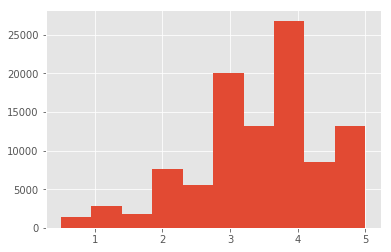

In [ ]:
df = pd.read_csv('ratings.csv')
df_pivot = pd.pivot_table(df, values = 'rating', index = 'userId', columns = 'movieId').fillna(0)

data_matrix = np.array(df_pivot)
plt.style.use('ggplot')
plt.hist(df['rating'])
print(len(np.unique(df['movieId'])))
print(len(np.unique(df['userId'])))
print(610*9724)
print(len(df['rating'])/ (610*9724)*100)
print(len(data_matrix),len(data_matrix[0]))

In [ ]:
train_data, test_data = cv.train_test_split(data_matrix, test_size=0.4)

In [ ]:
print(data_matrix.shape)

(610, 9724)


In [ ]:
# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0

# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0

In [ ]:
print(item_correlation)

[[ 1.          0.21035945  0.1963873  ... -0.03587593 -0.03587593
  -0.03587593]
 [ 0.21035945  1.          0.30175254 ... -0.02356604 -0.02356604
  -0.02356604]
 [ 0.1963873   0.30175254  1.         ... -0.01564028 -0.01564028
  -0.01564028]
 ...
 [-0.03587593 -0.02356604 -0.01564028 ...  1.          1.
  -0.00273973]
 [-0.03587593 -0.02356604 -0.01564028 ...  1.          1.
  -0.00273973]
 [-0.03587593 -0.02356604 -0.01564028 ... -0.00273973 -0.00273973
   1.        ]]


In [ ]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        #mean_user_rating = ratings.mean(axis=1)
        mean_user_rating = ratings.sum(axis=1)/(ratings != 0).sum(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [ ]:
# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data, user_correlation, type='user')
item_prediction = predict(train_data.T, item_correlation, type='item')

In [ ]:
# Linear mapping of ratings to scale [1,5]
user_prediction = np.interp(user_prediction, (user_prediction.min(), user_prediction.max()), (1, 5))
item_prediction = np.interp(item_prediction, (item_prediction.min(), item_prediction.max()), (1, 5))


In [ ]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data)))

print(user_prediction)

User-based CF RMSE: 1.53362203438
Item-based CF RMSE: 1.42965182492
[[2.9541798  2.35449671 2.02134112 ... 1.7850756  1.7850756  1.79279123]
 [3.37463357 2.77067019 2.51171815 ... 2.35478614 2.35478614 2.36374941]
 [2.64991451 2.16157797 1.91883187 ... 1.72233334 1.72233334 1.72288346]
 ...
 [2.3236875  1.75818901 1.48551643 ... 1.28530291 1.28530291 1.29589733]
 [3.27747937 2.80673227 2.49467414 ... 2.19821327 2.19821327 2.20156283]
 [3.33595259 2.53288706 2.24658578 ... 2.08346737 2.08346737 2.09706409]]


In [ ]:
print(recmetrics.coverage(train_data ,user_prediction))
print(recmetrics.recommender_recall(train_data, user_prediction))
#recmetrics.precision_recall_plot(train_data, user_prediction)